In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import scipy.io as sio
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pywt
import random
import os



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)



Using device: cuda
Mounted at /content/drive


In [2]:

RAW_DATA_PATH = "Indian_pines_corrected.mat"
GT_PATH = "Indian_pines_gt.mat"

PATCH_SIZE = 25
N_COMPONENTS = 30
TRAIN_RATIO = 0.70
NUM_CLASSES = 16
BATCH_SIZE = 256

OUTPUT_DIR = "preprocessed_indianpines"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:


print(f"Loading data from {RAW_DATA_PATH} and {GT_PATH}...")
try:

    data_mat = sio.loadmat(RAW_DATA_PATH)
    gt_mat = sio.loadmat(GT_PATH)
    data = data_mat['indian_pines_corrected'].astype(np.float32)
    gt = gt_mat['indian_pines_gt']
except FileNotFoundError as e:
    print(f"Error loading raw data: {e}. Check RAW_DATA_PATH and GT_PATH.")
    raise

H, W, B = data.shape
print(f"Original data shape: {data.shape}, GT shape: {gt.shape}")

data_reshaped = data.reshape(-1, B)
band_mean = data_reshaped.mean(axis=0)
band_std = data_reshaped.std(axis=0) + 1e-12
data_norm = (data_reshaped - band_mean) / band_std

pca = PCA(n_components=N_COMPONENTS, whiten=True, random_state=SEED)
data_pca_flat = pca.fit_transform(data_norm)
data_pca = data_pca_flat.reshape(H, W, N_COMPONENTS)

joblib.dump(
    {'pca': pca, 'mean': band_mean, 'std': band_std},
    os.path.join(OUTPUT_DIR, 'pca_and_norm.joblib')
)
print(f"Data reduced to {N_COMPONENTS} components. Shape: {data_pca.shape}")

data_folder = OUTPUT_DIR

Loading data from /content/drive/MyDrive/Indian_pines_corrected.mat and /content/drive/MyDrive/Indian_pines_gt.mat...
Original data shape: (145, 145, 200), GT shape: (145, 145)
Data reduced to 30 components. Shape: (145, 145, 30)


In [4]:

pad = PATCH_SIZE // 2
H0, W0, _ = data_pca.shape

data_pad = np.pad(data_pca, ((pad, pad), (pad, pad), (0, 0)), mode='constant')
gt_pad = np.pad(gt, ((pad, pad), (pad, pad)), mode='constant')

patches = []
labels = []

for i in range(pad, pad + H0):
    for j in range(pad, pad + W0):
        lab = gt_pad[i, j]
        if lab == 0:
            continue
        patch = data_pad[i-pad:i+pad+1, j-pad:j+pad+1, :]
        patches.append(patch.astype(np.float32))
        labels.append(int(lab) - 1)

patches = np.array(patches)
labels = np.array(labels)
unique_labels = np.unique(labels)
print(f"Total extracted patches: {patches.shape}, total samples: {len(labels)}")

train_idx_list = []
test_idx_list = []

for c in unique_labels:
    idx_c = np.where(labels == c)[0]
    n_train = max(1, int(TRAIN_RATIO * len(idx_c)))
    tr_idx, te_idx = train_test_split(
        idx_c, train_size=n_train, random_state=SEED, shuffle=True
    )
    train_idx_list.append(tr_idx)
    test_idx_list.append(te_idx)

train_idx = np.concatenate(train_idx_list)
test_idx = np.concatenate(test_idx_list)

X_train = patches[train_idx]
y_train = labels[train_idx]
X_test = patches[test_idx]
y_test = labels[test_idx]

perm = np.random.RandomState(SEED).permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]

print("--- Final Data Shapes ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Total extracted patches: (10249, 25, 25, 30), total samples: 10249
--- Final Data Shapes ---
X_train shape: (7168, 25, 25, 30), y_train shape: (7168,)
X_test shape: (3081, 25, 25, 30), y_test shape: (3081,)


In [5]:

mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

class HSIDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx].astype(np.float32)
        y = self.y[idx]

        if self.augment:
            if random.random() > 0.5:
                x = np.flip(x, axis=0).copy()
            if random.random() > 0.5:
                x = np.flip(x, axis=1).copy()
            # Rotate 90/180/270 degrees (only spatial axes H, W)
            if random.random() > 0.5:
                k = random.choice([1, 2, 3])
                x = np.rot90(x, k, axes=(0, 1)).copy()

        # Convert to PyTorch Tensor: HxWxB
        x = torch.from_numpy(x).float()
        y = torch.tensor(y).long()
        return x, y

# --- DataLoader Setup ---
train_dataset = HSIDataset(X_train, y_train, augment=True)
test_dataset = HSIDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with BATCH_SIZE={BATCH_SIZE}")

DataLoaders created with BATCH_SIZE=256


In [6]:
class Branch3DConv(nn.Module):
    def __init__(self, in_bands, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2).unsqueeze(1)
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

class BranchHaar1D(nn.Module):
    def __init__(self, in_bands, out_dim=128):
        super().__init__()
        sample = np.random.rand(in_bands)
        cA, cD = pywt.dwt(sample, 'haar')
        in_features = len(np.concatenate([cA, cD]))
        self.fc = nn.Linear(in_features, out_dim)

    def forward(self, x):
        x_avg = x.mean(dim=1).mean(dim=1)
        coeffs_list = []
        for i in range(x_avg.shape[0]):
            arr = x_avg[i].detach().cpu().numpy()
            cA, cD = pywt.dwt(arr, 'haar')
            coeffs_list.append(np.concatenate([cA, cD]))
        coeffs = torch.tensor(np.stack(coeffs_list), dtype=torch.float32, device=x.device)
        return self.fc(coeffs)

class BranchHaar2D(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()

        patch_size = PATCH_SIZE
        sample = np.random.rand(patch_size, patch_size)
        cA, (cH, cV, cD) = pywt.dwt2(sample, 'haar')
        in_features = len(np.concatenate([cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()]))
        self.fc = nn.Linear(in_features, out_dim)

    def forward(self, x):
        x_avg = x.mean(dim=3)
        coeffs_list = []
        for i in range(x_avg.shape[0]):
            arr = x_avg[i].detach().cpu().numpy()
            cA, (cH, cV, cD) = pywt.dwt2(arr, 'haar')
            coeffs_list.append(np.concatenate([cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()]))
        coeffs = torch.tensor(np.stack(coeffs_list), dtype=torch.float32, device=x.device)
        return self.fc(coeffs)

class BranchHaar3D(nn.Module):
    def __init__(self, in_bands, patch_size, out_dim=128):
        super().__init__()

        sample = np.random.rand(in_bands, patch_size, patch_size)

        coeffs = pywt.wavedecn(sample, 'haar', level=1)

        in_features = coeffs[0].size

        detail_coeffs_dict = coeffs[1][0] if isinstance(coeffs[1], list) else coeffs[1]
        for key in detail_coeffs_dict:
            in_features += detail_coeffs_dict[key].size

        self.in_features = in_features
        self.fc = nn.Linear(self.in_features, out_dim)

    def forward(self, x):
        x_perm = x.permute(0, 3, 1, 2)
        coeffs_list = []
        for i in range(x_perm.shape[0]):
            arr = x_perm[i].detach().cpu().numpy()

            coeffs = pywt.wavedecn(arr, 'haar', level=1)

            cA = coeffs[0].flatten()

            detail_coeffs_dict = coeffs[1][0] if isinstance(coeffs[1], list) else coeffs[1]
            all_coeffs = [cA]
            for key in detail_coeffs_dict:
                all_coeffs.append(detail_coeffs_dict[key].flatten())

            coeffs_list.append(np.concatenate(all_coeffs))

        coeffs_np = np.stack(coeffs_list)
        coeffs_tensor = torch.tensor(coeffs_np, dtype=torch.float32, device=x.device)

        return self.fc(coeffs_tensor)

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channel, channel // reduction)
        self.fc2 = nn.Linear(channel // reduction, channel)

    def forward(self, x):

        y = x.mean(dim=0, keepdim=True)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        return x * y

class MultiBranchModelSE(nn.Module):
    def __init__(self, in_bands, num_classes, out_dim=128):
        super().__init__()
        patch_size = PATCH_SIZE

        self.branch1 = Branch3DConv(in_bands, out_dim)
        self.branch2 = BranchHaar1D(in_bands, out_dim)
        self.branch3 = BranchHaar2D(out_dim)
        self.branch4 = BranchHaar3D(in_bands, patch_size, out_dim)

        self.se1 = SEBlock(out_dim)
        self.se2 = SEBlock(out_dim)
        self.se3 = SEBlock(out_dim)
        self.se4 = SEBlock(out_dim)

        self.fc1 = nn.Linear(out_dim*4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        b1 = self.se1(self.branch1(x))
        b2 = self.se2(self.branch2(x))
        b3 = self.se3(self.branch3(x))
        b4 = self.se4(self.branch4(x))

        fused = torch.cat([b1, b2, b3, b4], dim=1)
        fused = F.relu(self.fc1(fused))
        fused = self.dropout(fused)
        return self.fc2(fused)


Model instantiated with 30 bands and 16 classes.

--- Starting Training ---


Epoch 1/50 [Train]: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it]


Epoch 1: Train Loss=2.3722, Train Acc=0.3916, Val Acc=0.5599, Val Loss=1.7992
Validation accuracy improved (55.99%). Model saved to best_model.pth


Epoch 2/50 [Train]: 100%|██████████| 28/28 [00:35<00:00,  1.28s/it]


Epoch 2: Train Loss=1.1750, Train Acc=0.6392, Val Acc=0.7348, Val Loss=0.7977
Validation accuracy improved (73.48%). Model saved to best_model.pth


Epoch 3/50 [Train]: 100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


Epoch 3: Train Loss=0.5143, Train Acc=0.7574, Val Acc=0.8072, Val Loss=0.4276
Validation accuracy improved (80.72%). Model saved to best_model.pth


Epoch 4/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.45s/it]


Epoch 4: Train Loss=0.3043, Train Acc=0.8442, Val Acc=0.8909, Val Loss=0.2857
Validation accuracy improved (89.09%). Model saved to best_model.pth


Epoch 5/50 [Train]: 100%|██████████| 28/28 [00:41<00:00,  1.47s/it]


Epoch 5: Train Loss=0.1975, Train Acc=0.8938, Val Acc=0.9325, Val Loss=0.1931
Validation accuracy improved (93.25%). Model saved to best_model.pth


Epoch 6/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.42s/it]


Epoch 6: Train Loss=0.1286, Train Acc=0.9346, Val Acc=0.9539, Val Loss=0.1473
Validation accuracy improved (95.39%). Model saved to best_model.pth


Epoch 7/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.42s/it]


Epoch 7: Train Loss=0.0979, Train Acc=0.9538, Val Acc=0.9659, Val Loss=0.1275
Validation accuracy improved (96.59%). Model saved to best_model.pth


Epoch 8/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


Epoch 8: Train Loss=0.0728, Train Acc=0.9674, Val Acc=0.9721, Val Loss=0.0950
Validation accuracy improved (97.21%). Model saved to best_model.pth


Epoch 9/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


Epoch 9: Train Loss=0.0564, Train Acc=0.9750, Val Acc=0.9766, Val Loss=0.0778
Validation accuracy improved (97.66%). Model saved to best_model.pth


Epoch 10/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


Epoch 10: Train Loss=0.0407, Train Acc=0.9807, Val Acc=0.9799, Val Loss=0.0720
Validation accuracy improved (97.99%). Model saved to best_model.pth


Epoch 11/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


Epoch 11: Train Loss=0.0319, Train Acc=0.9856, Val Acc=0.9821, Val Loss=0.0659
Validation accuracy improved (98.21%). Model saved to best_model.pth


Epoch 12/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


Epoch 12: Train Loss=0.0304, Train Acc=0.9859, Val Acc=0.9834, Val Loss=0.0559
Validation accuracy improved (98.34%). Model saved to best_model.pth


Epoch 13/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


Epoch 13: Train Loss=0.0230, Train Acc=0.9901, Val Acc=0.9860, Val Loss=0.0603
Validation accuracy improved (98.60%). Model saved to best_model.pth
Early stopping counter: 1/5


Epoch 14/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.42s/it]


Epoch 14: Train Loss=0.0188, Train Acc=0.9916, Val Acc=0.9864, Val Loss=0.0624
Validation accuracy improved (98.64%). Model saved to best_model.pth
Early stopping counter: 2/5


Epoch 15/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


Epoch 15: Train Loss=0.0168, Train Acc=0.9941, Val Acc=0.9893, Val Loss=0.0452
Validation accuracy improved (98.93%). Model saved to best_model.pth


Epoch 16/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.43s/it]


Epoch 16: Train Loss=0.0136, Train Acc=0.9953, Val Acc=0.9906, Val Loss=0.0428
Validation accuracy improved (99.06%). Model saved to best_model.pth


Epoch 17/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.42s/it]


Epoch 17: Train Loss=0.0112, Train Acc=0.9964, Val Acc=0.9922, Val Loss=0.0455
Validation accuracy improved (99.22%). Model saved to best_model.pth
Early stopping counter: 1/5


Epoch 18/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.43s/it]


Epoch 18: Train Loss=0.0106, Train Acc=0.9960, Val Acc=0.9886, Val Loss=0.0395


Epoch 19/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


Epoch 19: Train Loss=0.0100, Train Acc=0.9961, Val Acc=0.9893, Val Loss=0.0419
Early stopping counter: 1/5


Epoch 20/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


Epoch 20: Train Loss=0.0076, Train Acc=0.9969, Val Acc=0.9906, Val Loss=0.0352


Epoch 21/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.43s/it]


Epoch 21: Train Loss=0.0075, Train Acc=0.9976, Val Acc=0.9925, Val Loss=0.0467
Validation accuracy improved (99.25%). Model saved to best_model.pth
Early stopping counter: 1/5


Epoch 22/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.42s/it]


Epoch 22: Train Loss=0.0079, Train Acc=0.9972, Val Acc=0.9896, Val Loss=0.0348


Epoch 23/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.43s/it]


Epoch 23: Train Loss=0.0073, Train Acc=0.9985, Val Acc=0.9909, Val Loss=0.0645
Early stopping counter: 1/5


Epoch 24/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.43s/it]


Epoch 24: Train Loss=0.0050, Train Acc=0.9980, Val Acc=0.9925, Val Loss=0.0661
Early stopping counter: 2/5


Epoch 25/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.43s/it]


Epoch 25: Train Loss=0.0046, Train Acc=0.9990, Val Acc=0.9935, Val Loss=0.0603
Validation accuracy improved (99.35%). Model saved to best_model.pth
Early stopping counter: 3/5


Epoch 26/50 [Train]: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


Epoch 26: Train Loss=0.0044, Train Acc=0.9986, Val Acc=0.9925, Val Loss=0.0494
Early stopping counter: 4/5


Epoch 27/50 [Train]: 100%|██████████| 28/28 [00:39<00:00,  1.43s/it]


Epoch 27: Train Loss=0.0039, Train Acc=0.9989, Val Acc=0.9932, Val Loss=0.0411
Early stopping counter: 5/5
Early stopping triggered. Stopping training.

Training Complete. Best Validation Accuracy: 99.35%


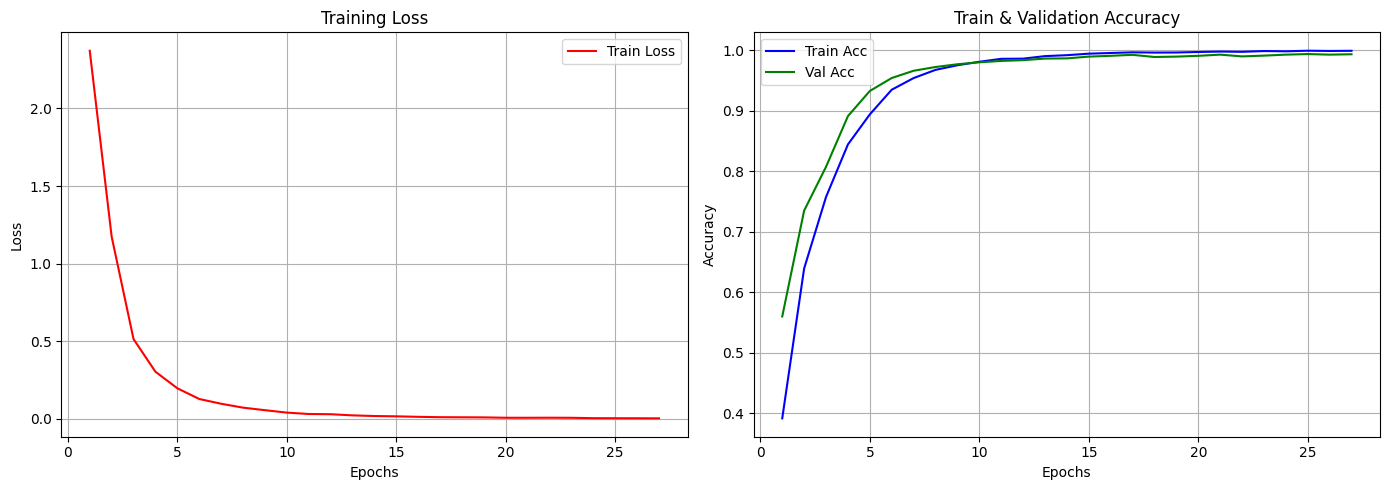

In [7]:
# --- 7. TRAINING EXECUTION ---

# --- Instantiate Model ---
in_bands = X_train.shape[-1]
model = MultiBranchModelSE(in_bands, NUM_CLASSES).to(device)
print(f"\nModel instantiated with {in_bands} bands and {NUM_CLASSES} classes.")

class_counts = np.bincount(y_train)
weights = 1.0 / (class_counts + 1e-6)
weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3,
)

# --- Training Loop Parameters ---
num_epochs = 50
best_acc = 0.0
checkpoint_path = "best_model.pth"

train_losses = []
train_accs = []
val_accs = []

# --- Early Stopping Parameters ---
patience = 5  # epochs to wait before stopping
best_val_loss = float("inf")
early_stop_counter = 0

print("\n--- Starting Training ---")
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    # --- Validation ---
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_acc = correct / total
    val_loss /= len(test_loader)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, "
          f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Loss={val_loss:.4f}")

    scheduler.step(val_loss)

    # --- Save Best Model ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Validation accuracy improved ({best_acc*100:.2f}%). Model saved to {checkpoint_path}")

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

print(f"\nTraining Complete. Best Validation Accuracy: {best_acc*100:.2f}%")

# --- Plotting Training History ---
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc", color="blue")
plt.plot(epochs_range, val_accs, label="Val Acc", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Loaded model from 'best_model.pth' for evaluation.

CLASSIFICATION REPORT & CONFUSION MATRIX


Evaluating Test Set: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]



Overall Test Accuracy: 99.3509%

Classification Report (Precision, Recall, F1-Score per class):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        14
           1     0.9953    0.9837    0.9894       429
           2     1.0000    0.9920    0.9960       249
           3     0.9730    1.0000    0.9863        72
           4     1.0000    0.9931    0.9965       145
           5     1.0000    1.0000    1.0000       220
           6     1.0000    1.0000    1.0000         9
           7     1.0000    1.0000    1.0000       144
           8     1.0000    1.0000    1.0000         6
           9     0.9898    0.9932    0.9915       292
          10     0.9919    0.9932    0.9925       737
          11     0.9888    0.9888    0.9888       178
          12     1.0000    1.0000    1.0000        62
          13     0.9948    1.0000    0.9974       380
          14     0.9915    1.0000    0.9957       116
          15     0.9310    0.9643    0

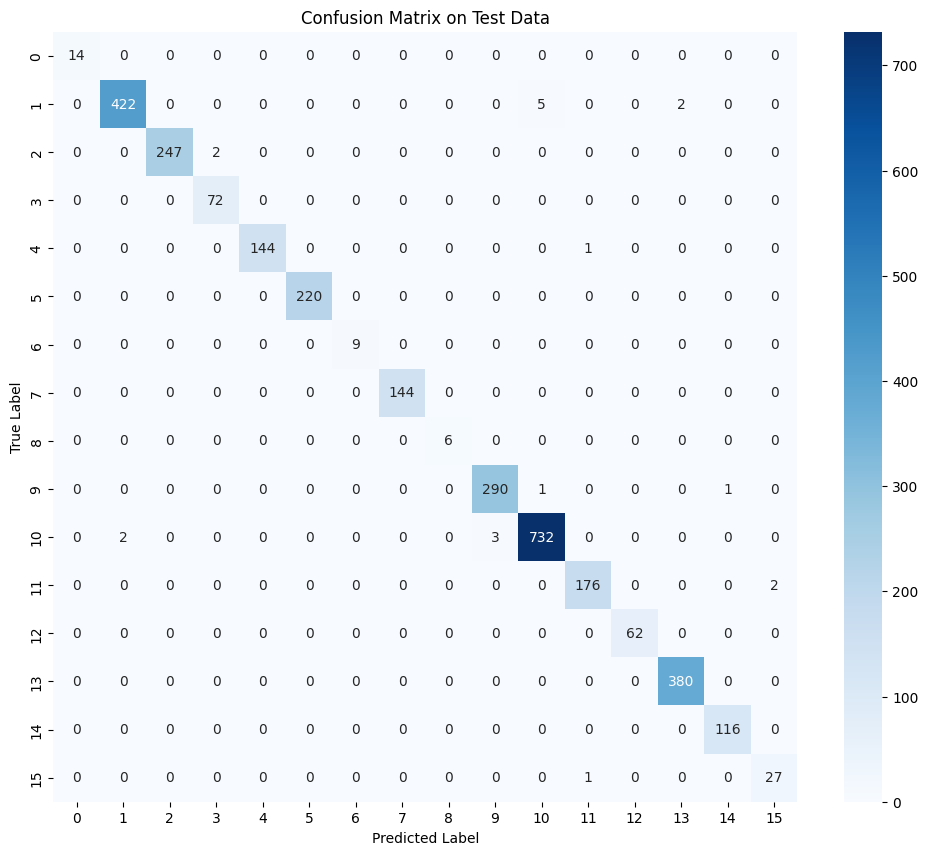

In [8]:
# ----------------------------------------------------
# 1. EVALUATION AND FULL IMAGE INFERENCE
# ----------------------------------------------------
import scipy.io as sio
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import seaborn as sns
import os
import torch # Import explicitly
from tqdm import tqdm # Import explicitly
import matplotlib.pyplot as plt # Import explicitly


num_classes = len(np.unique(y_train))
in_bands = X_train.shape[-1]
model = MultiBranchModelSE(in_bands, num_classes).to(device)
checkpoint_path = "best_model.pth"

try:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    print(f"\nLoaded model from '{checkpoint_path}' for evaluation.")

except FileNotFoundError:
    print("\nFATAL ERROR: 'best_model.pth' not found. Training must be run first.")
    raise

# ----------------------------------------------------
# 1. Classification Report (Testing Data)
# ----------------------------------------------------
print("\n" + "="*50)
print("CLASSIFICATION REPORT & CONFUSION MATRIX")
print("="*50)

# Run Inference on Test Set
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader, desc="Evaluating Test Set"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

# --- Generate Report and Confusion Matrix ---
accuracy = accuracy_score(y_true, y_pred)

print(f"\nOverall Test Accuracy: {accuracy*100:.4f}%")

# Classification Report
print("\nClassification Report (Precision, Recall, F1-Score per class):")
report = classification_report(y_true, y_pred, digits=4, zero_division=0)
print(report)

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
plt.show()



FULL IMAGE CLASSIFICATION MAP
Generating classification map for image shape 145x145...


Predicting Pixels: 100%|██████████| 21/21 [00:46<00:00,  2.21s/it]


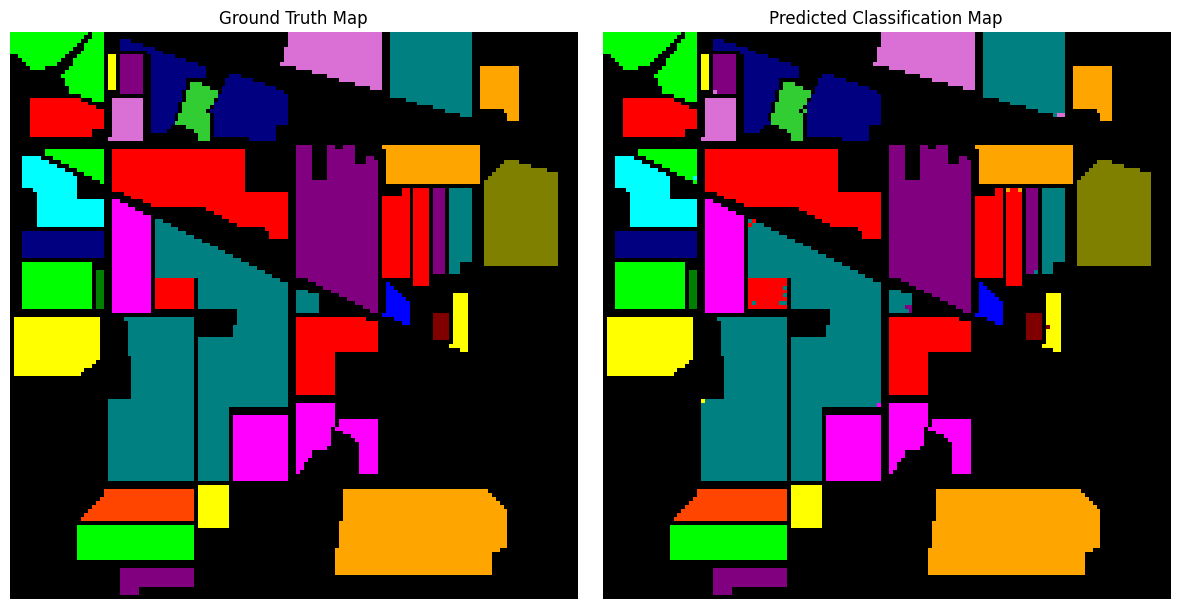

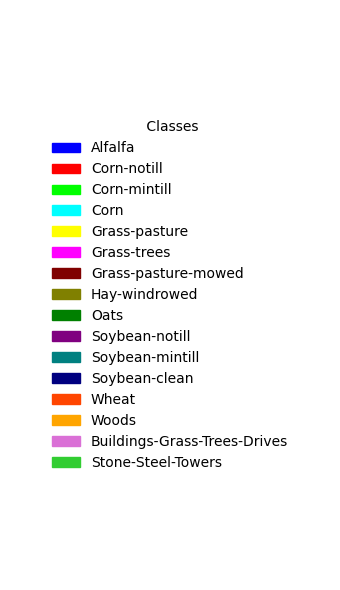

In [9]:
import matplotlib.patches as mpatches
# ----------------------------------------------------
# 2. Full Image Inference (Classification Map)
# ----------------------------------------------------
print("\n" + "="*50)
print("FULL IMAGE CLASSIFICATION MAP")
print("="*50)

try:
    # --- Load Raw Data from Google Drive ---
    data_raw = sio.loadmat(RAW_DATA_PATH)['indian_pines_corrected'].astype(np.float32)
    gt_map   = sio.loadmat(GT_PATH)['indian_pines_gt']
    H, W, B = data_raw.shape

    # Load the PCA/Norm parameters from the unzipped folder (local Colab storage)
    pca_file_path = os.path.join(data_folder, "pca_and_norm.joblib")
    pca_params = joblib.load(pca_file_path)
    pca = pca_params['pca']
    band_mean = pca_params['mean']
    band_std = pca_params['std']

    print(f"Generating classification map for image shape {H}x{W}...")

    # --- Apply Preprocessing to Full Image ---
    data_reshaped = data_raw.reshape(-1, B)
    data_norm = (data_reshaped - band_mean) / band_std
    data_pca_flat = pca.transform(data_norm)
    data_pca = data_pca_flat.reshape(H, W, -1).astype(np.float32)

    # --- Apply Training Local Normalization ---
    data_final = (data_pca - X_train.mean()) / X_train.std()


    # --- Extract Patches for Inference ---
    PATCH_SIZE = 25
    pad = PATCH_SIZE // 2
    data_pad = np.pad(data_final, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

    all_image_patches = []
    indices = []
    for i in range(H):
        for j in range(W):
            patch = data_pad[i:i + PATCH_SIZE, j:j + PATCH_SIZE, :]
            all_image_patches.append(patch)
            indices.append((i, j))

    all_image_patches = np.array(all_image_patches)

    # --- Run Inference (in batches) ---
    image_loader = DataLoader(all_image_patches, batch_size=1024, shuffle=False)
    full_preds = []

    with torch.no_grad():
        for X_batch in tqdm(image_loader, desc="Predicting Pixels"):
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            full_preds.append(preds.cpu())

    full_preds = torch.cat(full_preds).numpy()

    # --- Reconstruct Classification Map ---
    classification_map = np.zeros((H, W), dtype=np.uint8)

    for idx, (i, j) in enumerate(indices):
        classification_map[i, j] = full_preds[idx] + 1 # 0-indexed to 1-16 labels

    # Mask out background where GT is 0
    classification_map[gt_map == 0] = 0

    # --- Visualization ---
    from matplotlib.colors import ListedColormap
    # Standard Indian Pines colors
    colors = [
        '#000000', '#0000FF', '#FF0000', '#00FF00', '#00FFFF', '#FFFF00',
        '#FF00FF', '#800000', '#808000', '#008000', '#800080', '#008080',
        '#000080', '#FF4500', '#FFA500', '#DA70D6', '#32CD32'
    ]
    class_names=[
    "Background",               # Index 0
    "Alfalfa",                  # Index 1
    "Corn-notill",              # Index 2
    "Corn-mintill",             # Index 3
    "Corn",                     # Index 4
    "Grass-pasture",            # Index 5
    "Grass-trees",              # Index 6
    "Grass-pasture-mowed",      # Index 7
    "Hay-windrowed",            # Index 8
    "Oats",                     # Index 9
    "Soybean-notill",           # Index 10
    "Soybean-mintill",          # Index 11
    "Soybean-clean",            # Index 12
    "Wheat",                    # Index 13
    "Woods",                    # Index 14
    "Buildings-Grass-Trees-Drives", # Index 15
    "Stone-Steel-Towers"        # Index 16
]
    cmap = ListedColormap(colors[:num_classes+1])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_map, cmap=cmap, vmin=0, vmax=num_classes)
    plt.title('Ground Truth Map')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(classification_map, cmap=cmap, vmin=0, vmax=num_classes)
    plt.title('Predicted Classification Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    legend_patches = []
    for i in range(1, num_classes + 1):
        color = colors[i]
        name = class_names[i]
        # Create a colored patch for the legend
        patch = mpatches.Patch(color=color, label=name)
        legend_patches.append(patch)

    # Create the legend plot
    plt.figure(figsize=(3.5, 6))
    plt.legend(handles=legend_patches,
              loc='center',
              ncol=1,
              frameon=False,
              title=" Classes")
    plt.gca().set_axis_off() # Hide the axes
    plt.tight_layout()
    plt.show()


except FileNotFoundError as e:
    print(f"\nSkipping Classification Map. A file was not found: {e}.")
    print("Ensure you confirmed the raw data file paths inside the script are correct.")

In [ ]:
# Assuming the classification cell just ran successfully.

# --- Define Results Directory ---
RESULTS_DIR = "Results"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"\nCreated results directory: {RESULTS_DIR}")

# --- 1. Save Combined Map Image (GT and Prediction) ---

# Re-creating the figure using the variables already in memory
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# gt_map and cmap should be available from the previous cell
plt.imshow(gt_map, cmap=cmap, vmin=0, vmax=NUM_CLASSES)
plt.title('Ground Truth Map')
plt.axis('off')

plt.subplot(1, 2, 2)
# classification_map and cmap should be available from the previous cell
plt.imshow(classification_map, cmap=cmap, vmin=0, vmax=NUM_CLASSES)
plt.title('Predicted Classification Map')
plt.axis('off')

plt.tight_layout()
SAVE_PATH_MAP = os.path.join(RESULTS_DIR, 'IndianPines_Classification_Maps.png')
plt.savefig(SAVE_PATH_MAP, bbox_inches='tight', dpi=300)
plt.close()
print(f"Saved combined GT and Prediction map to: {SAVE_PATH_MAP}")


# --- 2. Save Classification Map (as raw data) ---

# Saving the raw numpy array of predictions for later use
np.save(os.path.join(RESULTS_DIR, 'predicted_map_raw.npy'), classification_map)
print(f"Saved raw predicted map data to: {os.path.join(RESULTS_DIR, 'predicted_map_raw.npy')}")


# --- 3. Save Legend Image ---

# Re-generating the legend_patches list using existing variables
legend_patches = []
for i in range(1, NUM_CLASSES + 1):
    # colors and class_names should be available from the previous cell
    color = colors[i]
    name = class_names[i]
    patch = mpatches.Patch(color=color, label=name)
    legend_patches.append(patch)

plt.figure(figsize=(3.5, 6))
plt.legend(handles=legend_patches,
           loc='center',
           ncol=1,
           frameon=False,
           title=" Classes")
plt.gca().set_axis_off()
plt.tight_layout()

SAVE_PATH_LEGEND = os.path.join(RESULTS_DIR, 'IndianPines_Legend.png')
plt.savefig(SAVE_PATH_LEGEND, bbox_inches='tight', dpi=300)
plt.close()
print(f"Saved legend image to: {SAVE_PATH_LEGEND}")

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true, y_pred)

SAVE_PATH_REPORT = os.path.join(RESULTS_DIR, 'IndianPines_Testing_Report.txt')

with open(SAVE_PATH_REPORT, 'w') as f:
    f.write("--- Quantitative Classification Results on Test Set ---\n")
    f.write(f"Overall Test Accuracy (OA): {accuracy * 100:.4f}%\n")
    f.write(f"Kappa Coefficient (Kappa): {kappa:.4f}\n")
    f.write("\n" + "="*50 + "\n")
    f.write("Detailed Classification Report (Per-Class Metrics):\n")
    f.write(report) # The 'report' variable is the string output from classification_report()

print(f" Saved Quantitative Report to: {SAVE_PATH_REPORT}")

# --- 2. Save Confusion Matrix Plot ---

# Adjust labels to exclude 'Background' if your model was trained on 0-15 labels
# Your evaluation code used range(num_classes) which is 0-15.
plot_labels = class_names[1 : num_classes + 1] # Use the actual class names

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=plot_labels,
    yticklabels=plot_labels
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')

SAVE_PATH_CM = os.path.join(RESULTS_DIR, 'IndianPines_Confusion_Matrix_Test.png')
plt.savefig(SAVE_PATH_CM, bbox_inches='tight', dpi=300)
plt.close()

print(f" Saved Confusion Matrix plot to: {SAVE_PATH_CM}")

 Saved Quantitative Report to: Results/IndianPines_Testing_Report.txt
 Saved Confusion Matrix plot to: Results/IndianPines_Confusion_Matrix_Test.png


In [ ]:
import torch
import os

MODEL_SAVE_PATH = os.path.join(RESULTS_DIR, 'final_model_state.pth')

torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"\n Successfully saved the final model state to: {MODEL_SAVE_PATH}")


 Successfully saved the final model state to: Results/final_model_state.pth


In [ ]:
import torch
import os

FULL_MODEL_SAVE_PATH = os.path.join(RESULTS_DIR, 'full_model.pth')

torch.save(model, FULL_MODEL_SAVE_PATH)

print(f"\n Successfully saved the full model object to: {FULL_MODEL_SAVE_PATH}")


 Successfully saved the full model object to: Results/full_model.pth
